In [1]:
library(ggplot2)
library(dplyr)
library(gplots)
library(ggpmisc)
library(ggpubr)
library(reshape2)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(heatmap.plus)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: ggpp


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate


Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom

Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    gen

In [2]:
filtered <- read.table("../20230101_QC/final_summary_anno3.txt",header=T,sep="\t")
variant_list <- read.table("../variant_annotation/780_variant_annotation_COUPTF2_TBR1_DLX1_CBH.csv",header=T,sep=",",row.names=1)

In [3]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] #Use 269 variants. assign this to mosaic_filtered
shared_variant_list<-subset(variant_list, sample_number_presented_CBH>0)

# Heatmap with selected sorted nuclei and CBH_labeled variants

In [4]:
melt_mtcars<-mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region", "Cell_Type", "CTX_BG_HIP_relationship")]
melt_mtcars<-na.omit(melt_mtcars[melt_mtcars$CHROM.POS.REF.ALT %in% shared_variant_list$variant_list,])
melt_mtcars<-melt_mtcars[melt_mtcars$CTX_BG_HIP_relationship %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)

In [5]:
melt_mtcars<-na.omit(melt_mtcars)
length(unique(melt_mtcars$CHROM.POS.REF.ALT))

[1] 131

In [6]:
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Region+Organ+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Hemisphere)
unique(casted_MAF_VarBySample2$Organ)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)
dim(casted_MAF_VarBySample2)

[1] 12

[1] "R"

[1] "BG"  "CTX" "HIP"

[1] "Cau" "Put" "F"   "I"   "mO"  "O"   "P"   "GP"  "Hip" "T"

[1] "DLX1" "TBR1"

[1]  12 135

In [7]:
Normalized_casted_MAF_VarBySample2<-t(na.omit(t(casted_MAF_VarBySample2[,-1:-4])))
label<-t(na.omit(t(casted_MAF_VarBySample2[,1:4])))
label<-as.data.frame(label)

In [8]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             #Hemisphere = label$Hemisphere,
                                             Organ = label$Organ,
                                             Region = label$Region,
                                             Cell_Type = label$Cell_Type,
                                             #Cell_Type = label$Cell_Type,
                                             col = list(Organ = c("BG"="#CBDF00","CTX"="#00DF3D","HIP"="#9200DF"),
                                                       Region = c("Cau"="#A49A00",
                                                                  "GP"="#8EA400",
                                                                  "Put"="#75A400",
                                                                  "Hip"="#7E00A4",
                                                                  # "CA1"="#9000A4",
                                                                  # "CA3"="#A4009C",
                                                                  # "DG"="#A4007E",
                                                                   "I"="#28A400",
                                                                  "F"="#14A400",
                                                                  "O"="#00A40F",
                                                                  "P"="#00A437",
                                                                  "CC" = "#72A400",
                                                                  "EC"="#4FA400",
                                                                  "T"="#00A48B",
                                                                 "mO"="#00A49C"),
                                                       Cell_Type = c("DLX1" = "#EF6666", "TBR1" = "#7CBD42"))
                                             )

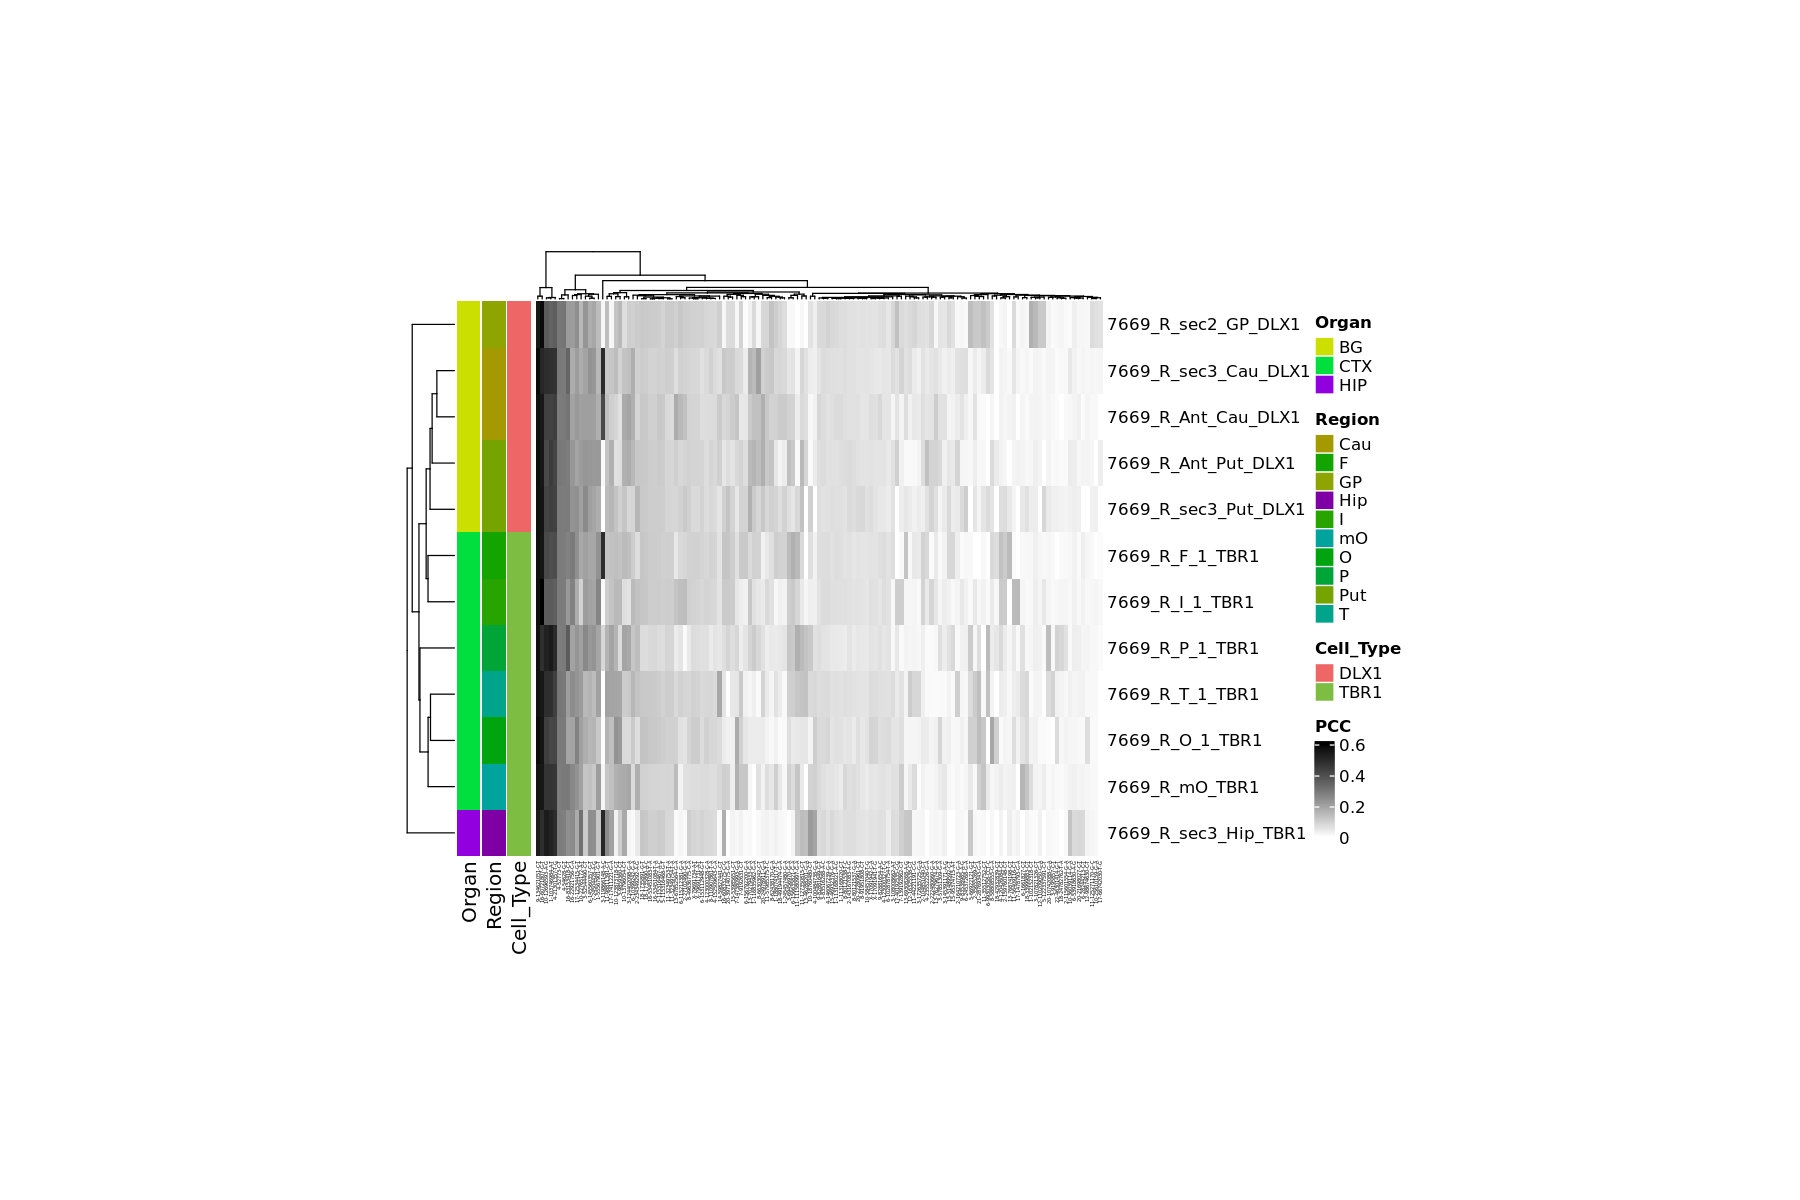

In [9]:
options(repr.plot.width = 15, repr.plot.height = 10)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "PCC",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(12, "cm"),
        heatmap_height = unit(14, "cm")) 
p

In [10]:
pdf(file="7669_VarBySample_CTX_BG_HIP_heatmap.pdf",height=24,width=40)
p
dev.off()   

png 
  2

# Bias plot with bulk data

In [11]:
working_variants<-shared_variant_list$variant_list
CTX <- subset(melt_mtcars, Organ %in% c('CTX'))
BG <- subset(melt_mtcars, Organ %in% c('BG'))
HIP <- subset(melt_mtcars, Organ %in% c('HIP'))
length(working_variants)
sum(CTX$MAF, na.rm = TRUE)/length(CTX$MAF)
sum(BG$MAF, na.rm = TRUE)/length(BG$MAF)
sum(HIP$MAF, na.rm = TRUE)/length(HIP$MAF)

delta<-data.frame()
for (i in 1:length(working_variants)){
    xx<-subset(CTX, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(BG, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,1]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

for (i in 1:length(working_variants)){
    xx<-subset(CTX, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(HIP, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,2]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

[1] 131

[1] 0.09250241

[1] 0.09572251

[1] 0.08785328

In [12]:
mean(delta[,1])
mean(delta[,2])
SEM_X<-sd(delta[,1]) / sqrt(length(delta[,1]))
SEM_Y<-sd(delta[,2]) / sqrt(length(delta[,2]))
lowerX<-mean(delta[,1])-SEM_X
upperX<-mean(delta[,1])+SEM_X
lowerY<-mean(delta[,2])-SEM_Y
upperY<-mean(delta[,2])+SEM_Y

[1] 0.2517247

[1] 0.4510005

png 
  2

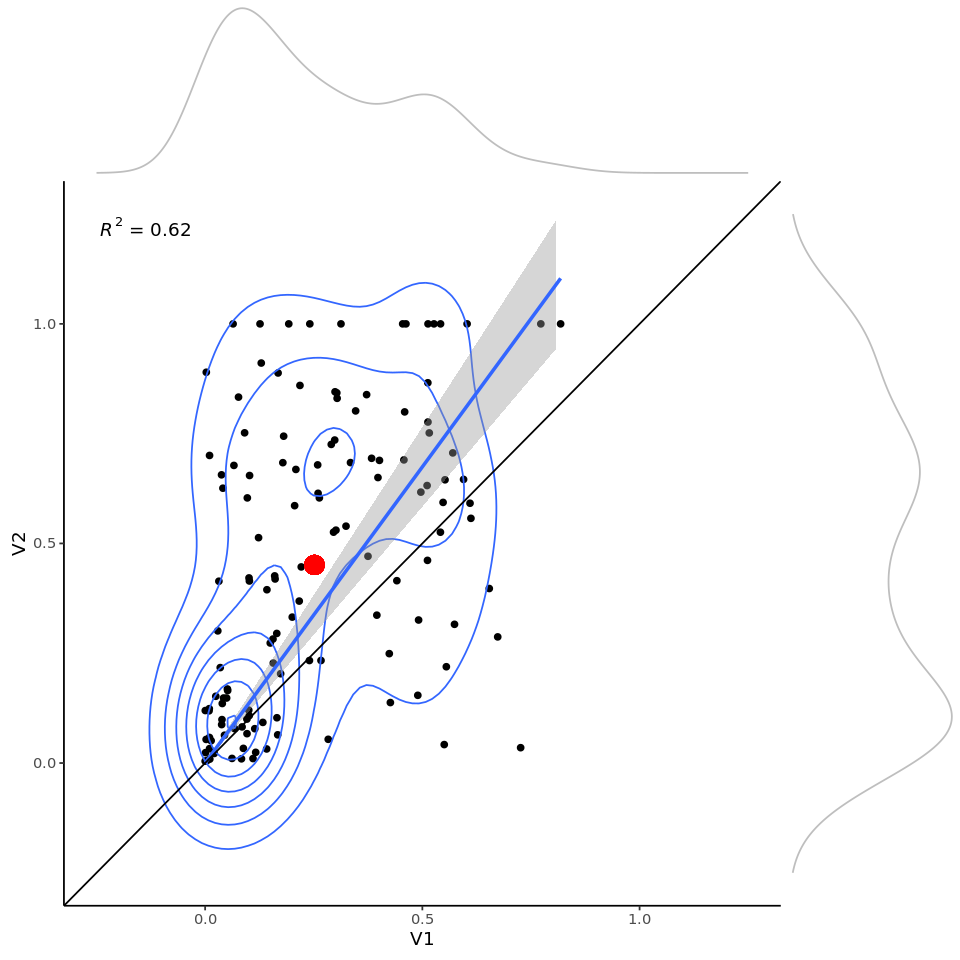

In [14]:
options(repr.plot.width = 8, repr.plot.height = 8)
formula <- y ~ x+0
p<-ggplot(delta, aes(x=V1, y=V2)) + geom_point()+xlim(-0.25,1.25)+ylim(-0.25,1.25)+theme_classic()+
    geom_density_2d()+stat_smooth(method = "lm", formula = y ~ x+0, geom = "smooth")+geom_abline(slope=1, intercept=0)+stat_poly_eq(formula = y ~ x+0,method = "lm")+
    geom_point(x = mean(delta[,1]), y = mean(delta[,2]), aes(x, y), size = 5, color = "red")
ggMarginal(p, color="grey", size=4)
pdf(file="7669_Bulk_CTX_BG_HIP_bias_plot.pdf",height=8,width=8)
 ggMarginal(p, color="grey", size=4)
 dev.off()    

# Bar graph for CTX BG HIP shared variant number

In [15]:
data<-as.data.frame(c(43,0,1))
colnames(data)<-"number"
rownames(data)<-c("CTX-BG","BG-HIP","CTX-HIP")
data

,number
,<dbl>
CTX-BG,43
BG-HIP,0
CTX-HIP,1


In [16]:
xxx<-factor(rownames(data), level=c("CTX-BG","BG-HIP","CTX-HIP"))
options(repr.plot.width=5,repr.plot.height=6)
p<-ggplot(data=data, aes(x=xxx, y=number, fill=xxx)) +
geom_bar(colour="black",stat='identity')+theme_classic() + labs(x='Variant properties', colour = "Variant properties", fill="Variant properties")+
geom_text(aes(label=data$number, vjust = -0.5, size=2)) + theme(axis.text.x=element_text(angle=45, hjust=1))

In [17]:
pdf(file="7669_CTX_BG_HIP_exclusively_shared_var.pdf",height=6,width=5)
p
dev.off()

png 
  2

# Permutation test

In [19]:
set.seed(123)
Region_Celltype<-3
temp2<-c()
df<-as.data.frame(t(matrix(ncol=0,nrow=3)))
for (j in 1:10000){
    for (i in 1:44){
        vector <- rep(0, Region_Celltype)
        # Choose 10 random positions to place ones
        random_positions <- sample(1:3, 2)
        vector[random_positions] <- 1
        if(vector[1]+vector[2]==2){
            df<-rbind(df,c(1,0,0))
        }
        if(vector[2]+vector[3]==2){
            df<-rbind(df,c(0,1,0))
        }
        if(vector[1]+vector[3]==2){
            df<-rbind(df,c(0,0,1))
        }
    }
    temp2[j]<-sum(df[,1])
    df<-as.data.frame(t(matrix(ncol=0,nrow=3)))
}

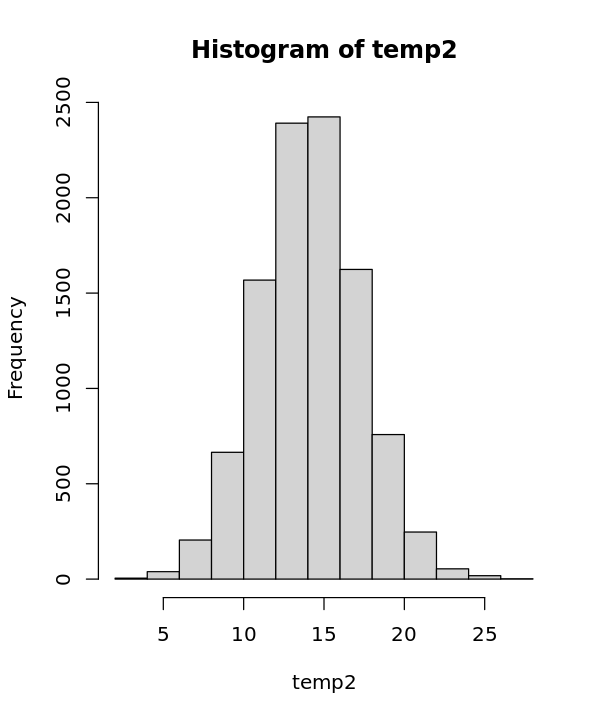

In [20]:
hist(temp2)

In [22]:
(length(temp2[temp2>=43])/length(temp2))*100

[1] 0